In [229]:
import geopandas as gpd
import pandas as pd
import ipyparallel as ipp
import requests
import xml.etree.ElementTree as ET
import json
from pyproj import Transformer
import functools
from tqdm import tqdm
import numpy as np
from shapely.geometry import Point,box
import matplotlib.pyplot as plt
import re
import pickle
import warnings
from pandas.errors import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)

In [99]:
grid = gpd.read_file("grid.gpkg")
aem = gpd.read_file("AEM.gpkg")
nldas = gpd.read_file("NLDAS_5021.gpkg")
surfaces = pd.read_csv("surfaces_5021.csv")

In [27]:
def get_cdl_value(year, lon, lat):
    """
    Fetches and parses the CDL value for a given year, lon, and lat coordinates.

    Args:
        year (int): The year of the data.
        lon (float): The longitude.
        lat (float): The latitude.

    Returns:
        dict: A dictionary containing the result data.
              Returns None if the request fails or the Result element is not found.
    """
    transformer = Transformer.from_crs("epsg:4326", "epsg:5070", always_xy=True)
    x, y = transformer.transform(lon, lat)
    url = f"https://nassgeodata.gmu.edu/axis2/services/CDLService/GetCDLValue?year={year}&x={x}&y={y}"
    response = requests.get(url)

    if response.status_code == 200: # success
        root = ET.fromstring(response.content)
        result_element = root.find(".//Result")

        if result_element is not None:
            result_string = result_element.text
            # weird xml format fix
            result_string = result_string.replace("{", "{\"").replace(":", "\":").replace(", ", ", \"")
            result_dict = json.loads(result_string)
            return result_dict
        else:
            print("Result element not found in the XML response.")
            return None
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return None

In [16]:
crops = grid[["latitude", "longitude"]].copy()

In [29]:
def process_chunk(chunk, years):
    results = []
    for _, row in chunk.iterrows():
        row_result = {}
        for year in years:
            row_result[f'cdl_{year}'] = get_cdl_value(year, row['longitude'], row['latitude'])
        results.append(row_result)
    return pd.DataFrame(results)

In [40]:
chunk_size = 20

chunks = np.array_split(crops, len(crops) // chunk_size)

/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [41]:
rc = ipp.Client()
view = rc.load_balanced_view()
rc[:].execute("""import requests
import xml.etree.ElementTree as ET
import json
from pyproj import Transformer
import pandas as pd""")
rc[:].push({'get_cdl_value': get_cdl_value})


years = [2010, 2015, 2020]

async_results = []
for chunk in chunks:
    async_result = view.apply_async(process_chunk, chunk, years)
    async_results.append(async_result)

results = []
for async_result in tqdm(async_results, desc="Processing chunks"):
    results.append(async_result.get())




Processing chunks:   0%|          | 0/1320 [00:00<?, ?it/s]


Processing chunks:   0%|          | 1/1320 [00:36<13:15:43, 36.20s/it]


Processing chunks:   0%|          | 5/1320 [00:36<2:00:11,  5.48s/it] 


Processing chunks:   2%|▏         | 25/1320 [01:01<39:52,  1.85s/it] 


Processing chunks:   2%|▏         | 26/1320 [01:02<38:53,  1.80s/it]


Processing chunks:   2%|▏         | 32/1320 [01:03<26:48,  1.25s/it]


Processing chunks:   2%|▎         | 33/1320 [01:04<25:49,  1.20s/it]


Processing chunks:   3%|▎         | 39/1320 [01:04<16:20,  1.31it/s]


Processing chunks:   3%|▎         | 42/1320 [01:05<13:54,  1.53it/s]


Processing chunks:   4%|▎         | 49/1320 [01:30<39:45,  1.88s/it]


Processing chunks:   4%|▍         | 50/1320 [01:31<38:49,  1.83s/it]


Processing chunks:   4%|▍         | 51/1320 [01:32<36:30,  1.73s/it]


Processing chunks:   4%|▍         | 58/1320 [01:32<18:21,  1.15it/s]


Processing chunks:   5%|▍         | 60/1320 [01:34<19:29,  1.08it/s]


Process

In [43]:
result_df = pd.concat(results, ignore_index=True)

In [44]:
result_df.head()

,cdl_2010,cdl_2015,cdl_2020
0,"{'x': -2214207.3736121603, 'y': 2213482.950502...","{'x': -2214207.3736121603, 'y': 2213482.950502...","{'x': -2214207.3736121603, 'y': 2213482.950502..."
1,"{'x': -2213995.126075733, 'y': 2214222.5316881...","{'x': -2213995.126075733, 'y': 2214222.5316881...","{'x': -2213995.126075733, 'y': 2214222.5316881..."
2,"{'x': -2213782.900761387, 'y': 2214962.0354407...","{'x': -2213782.900761387, 'y': 2214962.0354407...","{'x': -2213782.900761387, 'y': 2214962.0354407..."
3,"{'x': -2213358.516814814, 'y': 2216440.8105907...","{'x': -2213358.516814814, 'y': 2216440.8105907...","{'x': -2213358.516814814, 'y': 2216440.8105907..."
4,"{'x': -2213146.3581905165, 'y': 2217180.081960...","{'x': -2213146.3581905165, 'y': 2217180.081960...","{'x': -2213146.3581905165, 'y': 2217180.081960..."


In [57]:
crops["cdl_2010"] = result_df["cdl_2010"]
crops["cdl_2015"] = result_df["cdl_2015"]
crops["cdl_2020"] = result_df["cdl_2020"]

In [64]:
crops["cdl_val_2010"]=crops.apply(lambda row: row.cdl_2010.get("value") if row.cdl_2010 else None, axis=1)
crops["cdl_val_2015"]=crops.apply(lambda row: row.cdl_2015.get("value") if row.cdl_2015 else None, axis=1)
crops["cdl_val_2020"]=crops.apply(lambda row: row.cdl_2020.get("value") if row.cdl_2020 else None, axis=1)

In [67]:
crops["cdl_category_2010"]=crops.apply(lambda row: row.cdl_2010.get("category") if row.cdl_2010 else None, axis=1)
crops["cdl_category_2015"]=crops.apply(lambda row: row.cdl_2015.get("category") if row.cdl_2015 else None, axis=1)
crops["cdl_category_2020"]=crops.apply(lambda row: row.cdl_2020.get("category") if row.cdl_2020 else None, axis=1)

In [70]:
geometry = [Point(xy) for xy in zip(crops['longitude'], crops['latitude'])]
crops = gpd.GeoDataFrame(crops, geometry=geometry)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


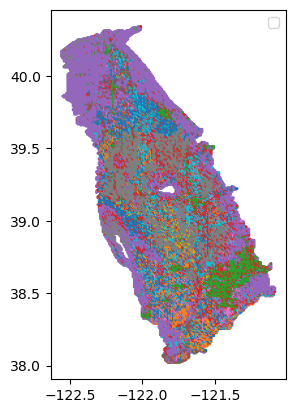

In [79]:
crops.plot("cdl_category_2010", markersize=1)

In [102]:
grid = pd.merge(grid, crops.drop(columns='geometry'), on=["latitude", "longitude"], how="left")

In [103]:
grid.drop(columns=["cdl_2010", "cdl_2015", "cdl_2020"], inplace=True)

In [112]:
col_dict = {}

for col in nldas.columns:
    match = re.match(r'(\d{4})(\d{2})_(\w+)', col)
    if match:
        year_str, month, attr = match.groups()
        year = int(year_str)
        if attr not in col_dict:
            col_dict[attr] = {}
        if year not in col_dict[attr]:
            col_dict[attr][year] = {}
        col_dict[attr][year][month] = col
    else:
        print(f"Column '{col}' does not match the expected pattern and will be skipped.")

Column 'lat' does not match the expected pattern and will be skipped.
Column 'lon' does not match the expected pattern and will be skipped.
Column 'geometry' does not match the expected pattern and will be skipped.


In [113]:
for attr, years in col_dict.items():
    for year in sorted(years.keys()):
        if '09' in years[year] and (year - 1 in years and '10' in years[year - 1]):
            sep_col = years[year]['09']           # September of year t.
            oct_prev_col = years[year - 1]['10']    # October of year t-1.
            new_col_name = f"{year}_sep_oct_diff_{attr}"
            nldas[new_col_name] = nldas[sep_col] - nldas[oct_prev_col]

In [118]:
def idw_interpolation(x_coords, y_coords, values, xi, yi, power=2, radius=None):
    """
    Compute the IDW interpolated value for the point (xi, yi).
    
    Parameters:
    - x_coords, y_coords: arrays of coordinates from the nldas data.
    - values: array of attribute values corresponding to the coordinates.
    - xi, yi: the coordinates of the target grid point.
    - power: power parameter for IDW.
    - radius: if provided, only points within this distance are considered.
    
    Returns:
    - interpolated value (or np.nan if no points fall within the radius)
    """
    distances = np.sqrt((x_coords - xi) ** 2 + (y_coords - yi) ** 2)
    if np.any(distances == 0):
        return values[distances == 0][0]
    
    if radius is not None:
        mask = distances < radius
        if not np.any(mask):
            return np.nan
        distances = distances[mask]
        values = values[mask]
    
    weights = 1 / distances ** power
    return np.sum(weights * values) / np.sum(weights)

In [146]:
client = ipp.Client()
dview = client[:]
lbview = client.load_balanced_view()

dview.push({
    'nldas_lon': nldas['lon'].values,
    'nldas_lat': nldas['lat'].values,
    'grid_lon': grid['longitude'].values,
    'grid_lat': grid['latitude'].values,
})

dview.execute("""
import numpy as np

def idw_interpolation(x_coords, y_coords, values, xi, yi, power=2, radius=None):
    # Compute Euclidean distances.
    distances = np.sqrt((x_coords - xi)**2 + (y_coords - yi)**2)
    
    # If the grid point coincides with a known point, return that value.
    if np.any(distances == 0):
        return values[distances == 0][0]
    
    # Optionally limit to points within a given radius.
    if radius is not None:
        mask = distances < radius
        if not np.any(mask):
            return np.nan
        distances = distances[mask]
        values = values[mask]
    
    weights = 1 / distances**power
    return np.sum(weights * values) / np.sum(weights)

def compute_attribute_idw(attr_values, power=2):
    # Compute the IDW interpolation for each grid point for a given attribute.
    results = []
    for xi, yi in zip(grid_lon, grid_lat):
        result = idw_interpolation(nldas_lon, nldas_lat, attr_values, xi, yi, power)
        results.append(result)
    return results
""")

def compute_attribute_idw(attr_values, power=2):
    results = []
    for xi, yi in zip(grid_lon, grid_lat):
        result = idw_interpolation(nldas_lon, nldas_lat, attr_values, xi, yi, power)
        results.append(result)
    return results

attributes = [col for col in nldas.columns if col not in ['lat', 'lon', 'geometry']]

power = 2

async_results = { 
    attr: lbview.apply_async(compute_attribute_idw, nldas[attr].values, power)
    for attr in attributes
}

for attr, async_result in tqdm(async_results.items()):
    grid[attr + '_idw'] = async_result.get()

100%|██████████| 1274/1274 [00:42<00:00, 30.02it/s]


In [166]:
surfaces_gdf = gpd.GeoDataFrame(
    surfaces, 
    geometry=gpd.points_from_xy(surfaces.longitude, surfaces.latitude)
)
surfaces_gdf.crs = "EPSG:4326"
surfaces_gdf = surfaces_gdf.to_crs(grid.crs)
joined = gpd.sjoin(surfaces_gdf, grid, how="left", predicate="within")
averages = joined.groupby('index_right').mean(numeric_only=True)

In [173]:
measurement_cols = [col for col in surfaces.columns if col not in ['latitude', 'longitude']]
averages = joined.groupby('index_right')[measurement_cols].mean()
grid = grid.join(averages, how='left')

In [178]:
def idw_interpolation(x, y, source_points, source_values, power=2):
    # Compute Euclidean distances from the grid cell's centroid (x, y) to each surface point.
    distances = np.sqrt((source_points[:, 0] - x) ** 2 + (source_points[:, 1] - y) ** 2)
    # If a surface point is exactly at the centroid, return its value to avoid division by zero.
    if np.any(distances == 0):
        return source_values[distances == 0][0]
    # Calculate weights as the inverse of distance raised to the specified power.
    weights = 1 / (distances ** power)
    return np.sum(weights * source_values) / np.sum(weights)

In [180]:
grid['centroid'] = grid.centroid
source_coords = np.array([(pt.x, pt.y) for pt in surfaces_gdf.geometry])
for col in tqdm(measurement_cols):
    final_vals = []
    source_values = surfaces_gdf[col].to_numpy()
    for idx, row in grid.iterrows():
        if pd.notnull(row[col]):
            final_vals.append(row[col])
        else:
            cx, cy = row['centroid'].x, row['centroid'].y
            interp_val = idw_interpolation(cx, cy, source_coords, source_values, power=2)
            final_vals.append(interp_val)
    grid[col + '_final'] = final_vals
grid = grid.drop(columns='centroid')

100%|██████████| 8/8 [00:57<00:00,  7.14s/it]


In [201]:
aem_15 = aem[aem.Interval_Type == "Average, 0-15m"].copy()

In [215]:
grid_centers = grid.copy()
grid_centers['geometry'] = gpd.points_from_xy(grid_centers.longitude, grid_centers.latitude)
grid_centers.crs = "EPSG:4326"

aem_15 = aem_15.to_crs(grid_centers.crs)

grid_joined = gpd.sjoin(grid_centers, aem_15[['PercentCoarse', 'geometry']], 
                        how="left", predicate="within")

# In case a grid center falls within more than one polygon, group by the grid's index and take the first match.
grid_joined_unique = grid_joined.groupby(grid_joined.index).first()

In [217]:
grid['PercentCoarse'] = grid_joined_unique['PercentCoarse']

In [220]:
grid.columns

Index(['color', 'gradient', 'p_slope', 'ones', 'longitude', 'latitude',
       'geometry', 'cdl_val_2010', 'cdl_val_2015', 'cdl_val_2020',
       ...
       'actual_slope_med', 'dry_avg_gwe_final', 'wet_avg_gwe_final',
       'diff_gwe_final', 'slope_final', 'slope_sig_final', 'slope_fdr_final',
       'actual_slope_avg_final', 'actual_slope_med_final', 'PercentCoarse'],
      dtype='object', length=1304)

In [221]:
numeric_cols = grid.select_dtypes(include=[np.number]).columns

for col in tqdm(numeric_cols):
    # Create a flag column that indicates if the original value was NaN
    flag_col = f"{col}_was_nan"
    grid[flag_col] = grid[col].isna().astype(int)  # 1 if NaN, 0 otherwise
    grid[col] = grid[col].fillna(-9999)

100%|██████████| 1298/1298 [00:01<00:00, 799.06it/s]


In [225]:
cols_to_encode = ['cdl_category_2010', 'cdl_category_2015', 'cdl_category_2020']
grid = pd.get_dummies(grid, columns=cols_to_encode)

In [227]:
bool_cols = grid.select_dtypes(include=['bool']).columns
grid[bool_cols] = grid[bool_cols].astype(int)

In [232]:
grid_save = grid.copy()

In [239]:
skip_columns = ['latitude', 'longitude']

for col in tqdm(numeric_cols):
    if col in skip_columns:
        continue
    valid_values = grid.loc[grid[col] != -9999, col]
    if valid_values.empty:
        continue
    if set(valid_values.unique()).issubset({0, 1}):
        continue
    mean_val = valid_values.mean()
    std_val = valid_values.std()
    if std_val == 0:
        std_val = 1
    valid_mask = grid[col] != -9999
    grid.loc[valid_mask, col] = (grid.loc[valid_mask, col] - mean_val) / std_val

100%|██████████| 1298/1298 [00:10<00:00, 120.48it/s]
